# Cluster based on words

Let's go through important words and assign clusters accorbing to them

In [1]:
import pandas as pd
import numpy as np
import tqdm

In [2]:
import gensim
from gensim.models import KeyedVectors

from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Let's just take not a very large pretrained word embeddings
# For better performance I suggest to use fastText.

import os

if not os.path.exists('data/18.zip'):
  !wget http://vectors.nlpl.eu/repository/11/18.zip -O data/18.zip

if not os.path.exists('data/model.txt'):
  !cd data ;unzip 18.zip


In [5]:
w2v = KeyedVectors.load_word2vec_format('./data/model.txt')

In [6]:
class EmbeddingsVectorizer(TransformerMixin):
    def __init__( self, w2v ):
        self.word2vec = w2v 
        
    def fit(self, X, y=None):
        return self # Don't need to fit this 
    
    def _phrase_vector(self, text):
        vectors = [self.word2vec.get_vector(x) for x in text.split() if x in self.word2vec.vocab]
        if len(vectors) == 0:
            return np.zeros(self.word2vec.vector_size)
        return np.mean(vectors, axis=0)
    
    #Method that describes what we need this transformer to do
    def transform(self, X, y=None):
        return np.stack(list(map(self._phrase_vector, X)))

In [7]:
ev = EmbeddingsVectorizer(w2v)

In [8]:
df = pd.read_csv('./data/cleaned_items.csv').fillna("")

In [9]:
sample_df = df.sample(3000)

In [41]:
sample_names = sample_df.clean_name

In [42]:
vectors = ev.fit_transform(sample_names)

In [64]:
X_embedded = TSNE(n_components=2, perplexity=100).fit_transform(vectors)

In [65]:
sample_df['x_plot'] = X_embedded[:, 0]
sample_df['y_plot'] = X_embedded[:, 1]

In [66]:
vocab = pd.read_csv('./data/vocab.csv')

In [67]:
sample_df['cluster'] = 0
sample_df['label'] = ''

In [68]:
for idx, word_row in enumerate(vocab.head(20).itertuples()):
    mask = sample_df.clean_name.str.contains(word_row.token) & (sample_df.cluster == 0)
    sample_df.loc[mask, 'cluster'] = idx + 1
    sample_df.loc[mask, 'label'] = word_row.token

In [69]:
max(sample_df.cluster)

20

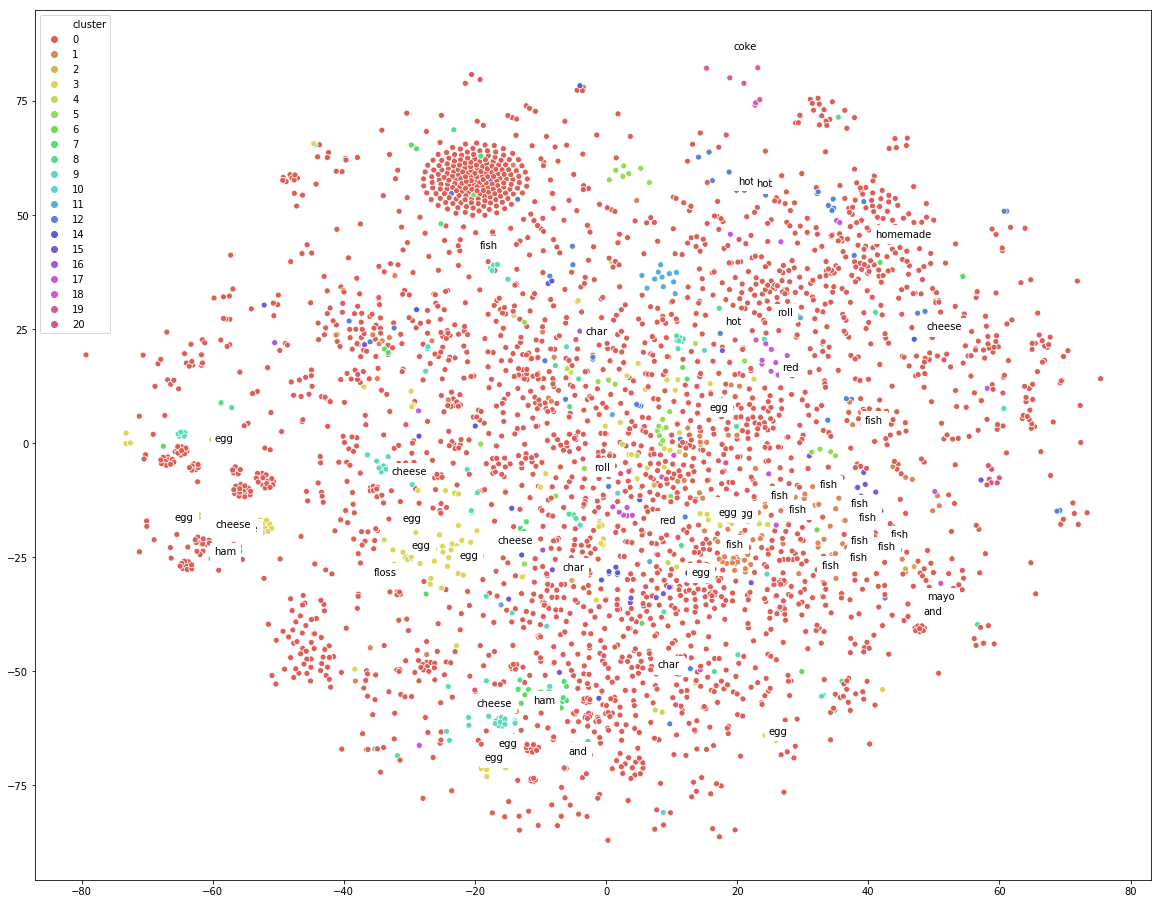

In [70]:
plt.figure(figsize=(20, 16))
pl = sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=sample_df.cluster,
    palette=sns.color_palette("hls", max(sample_df.cluster))
)

for row in sample_df.sample(200).itertuples():
    pl.text(row.x_plot, row.y_plot, row.label, fontdict={'backgroundcolor': 'white'})